In [204]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf

In [205]:
tsla = yf.Ticker("tsla")

tsla_hist = tsla.history(period='5y', interval='1d', end='2025-06-13')
tsla_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-06-19 00:00:00-04:00,67.518669,67.731331,66.089333,66.726669,130195500,0.0,0.0
2020-06-22 00:00:00-04:00,66.663330,67.258667,66.001335,66.288002,95436000,0.0,0.0
2020-06-23 00:00:00-04:00,66.592003,67.466667,66.267334,66.785332,95479500,0.0,0.0
2020-06-24 00:00:00-04:00,66.274002,66.725334,63.542667,64.056664,164394000,0.0,0.0
2020-06-25 00:00:00-04:00,63.618000,65.732002,62.476665,65.732002,138817500,0.0,0.0
...,...,...,...,...,...,...,...
2025-06-11 00:00:00-04:00,334.399994,335.500000,322.500000,326.429993,122611400,0.0,0.0
2025-06-12 00:00:00-04:00,323.079987,332.559998,316.859985,319.109985,105127500,0.0,0.0
2025-06-13 00:00:00-04:00,313.970001,332.989990,313.299988,325.309998,128964300,0.0,0.0


In [206]:
tsla_hist.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

In [207]:
tsla_hist.index =pd.to_numeric(tsla_hist.index)
tsla_hist.index = tsla_hist.index/(max(tsla_hist.index))

In [208]:
for col in tsla_hist.columns:
    tsla_hist[col] = tsla_hist[col]/max(tsla_hist[col])

In [209]:
X = tsla_hist.drop(columns=['Close'])
y = tsla_hist['Close']

In [210]:
X['Date'] = X.index

In [211]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

pca.fit(X, y)

PCA(n_components=5)

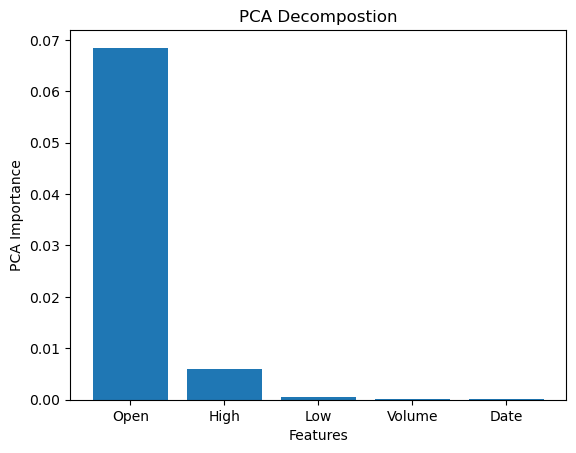

In [212]:
import matplotlib.pyplot as plt

plt.bar(X.columns, pca.explained_variance_)
plt.xlabel('Features')
plt.ylabel('PCA Importance')
plt.title("PCA Decompostion")
plt.show()

In [213]:
for delay in range(1,4):
    X[f"Delay {delay}"] = y.iloc[(3-delay):-(delay)]

In [215]:
X_sample = [[d, h, l, o, vol, v1, v2, v3] for d, h, l, o, vol, v1, v2, v3 in zip(X['Date'].iloc[3:].values, X['High'].iloc[3:].values, X['Low'].iloc[3:].values,X['Open'].iloc[3:].values, X['Volume'].iloc[3:].values, X['Delay 1'].dropna().values, X['Delay 2'].dropna().values, X['Delay 3'].dropna().values)]
y_sample = y.iloc[3:].values

In [216]:
len(X['Date'].iloc[3:].values), len(X_sample)

(1252, 1252)

In [234]:
for samples in X_sample:
    for sample in samples:
        if np.isnan(sample):
            print("contains nan")
        elif sample ==0:
            print("contains 0")

In [181]:
len(y_sample), len(X_sample)

(1252, 1252)

In [182]:
torch.set_default_dtype(torch.float64)

In [183]:
X = torch.from_numpy(np.array(X))
y = torch.from_numpy(np.array(y))

In [184]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [185]:
len(X_test)

251

In [186]:
train_data = [(X,y) for X, y in zip(X[:-273], y[:-273])]
test_data = [(X,y) for X, y in zip(X[-273:], y[-273:])]

In [187]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloaader= DataLoader(test_data, batch_size=32, shuffle=True)

In [202]:
test_trues = []

for (X, y) in train_dataloader:
    # if np.isnan(X):
    #     test_trues.append(X)
    # if np.isnan(y):
    #     test_trues.append(y)
    print(X)

tensor([[0.5859, 0.5810, 0.6068, 0.1974, 0.9648, 0.5887, 0.5887, 0.5887],
        [0.6294, 0.6264, 0.6392, 0.1155, 0.9434, 0.6123, 0.6123, 0.6123],
        [0.6331, 0.6519, 0.6450, 0.1225, 0.9437, 0.6617, 0.6617, 0.6617],
        [0.6134, 0.5985, 0.6258, 0.0838, 0.9492, 0.6042, 0.6042, 0.6042],
        [0.3915, 0.3883, 0.3993, 0.1751, 0.9609, 0.3898, 0.3898, 0.3898],
        [0.4104, 0.4044, 0.4186, 0.1183, 0.9763, 0.4001, 0.4001, 0.4001],
        [0.4862, 0.4866, 0.4984, 0.1321, 0.9232, 0.4918, 0.4918, 0.4918],
        [0.5069, 0.5197, 0.5263, 0.2413, 0.9728, 0.5232, 0.5232, 0.5232],
        [0.3700, 0.3631, 0.3655, 0.2365, 0.9621, 0.3501, 0.3501, 0.3501],
        [0.6243, 0.6113, 0.6350, 0.1041, 0.9209, 0.6134, 0.6134, 0.6134],
        [0.5279, 0.5251, 0.5392, 0.1776, 0.9680, 0.5179, 0.5179, 0.5179],
        [0.4622, 0.4567, 0.4715, 0.1754, 0.9710, 0.4630, 0.4630, 0.4630],
        [0.4031, 0.4024, 0.4089, 0.1458, 0.9263, 0.4007, 0.4007, 0.4007],
        [0.5824, 0.5851, 0.5770, 0.202

In [196]:
class MLP(nn.Module):
    def __init__(self, input_features, hidden_features, output_features):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Linear(input_features, hidden_features),
            nn.ReLU()
        )
        self.l2 = nn.Sequential(
            nn.Linear(hidden_features, output_features),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

In [197]:
mlpmodel = MLP(8, 15, 1)

In [198]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(params=mlpmodel.parameters(), lr=0.0001)

In [199]:
EPOCHS = 1

mlpmodel.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        preds = mlpmodel(X)
        print(f"Preds + {preds}")
        loss = loss_fn(torch.unsqueeze(y, 1), preds)
        total_loss+= loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(f"We're on batch: {batch} + Loss: {total_loss/batch}")


Preds + tensor([[0.0000],
        [0.0557],
        [0.0745],
        [0.1170],
        [0.0065],
        [0.0722],
        [0.0409],
        [0.0421],
        [0.0277],
        [0.0298],
        [0.0011],
        [0.0795],
        [0.0490],
        [0.0649],
        [0.0000],
        [0.0840],
        [0.0233],
        [0.1072],
        [0.0099],
        [0.0261],
        [0.0239],
        [0.0173],
        [0.0000],
        [0.0383],
        [0.0909],
        [0.0000],
        [0.0000],
        [0.1315],
        [0.0000],
        [0.0339],
        [0.0000],
        [0.0600]], grad_fn=<ReluBackward0>)
Preds + tensor([[0.0000],
        [0.0949],
        [0.0000],
        [0.1450],
        [0.0378],
        [0.0635],
        [0.0000],
        [0.1073],
        [0.0703],
        [0.0946],
        [0.0000],
        [0.0000],
        [0.1408],
        [0.0701],
        [0.0386],
        [0.0242],
        [0.0594],
        [0.0187],
        [0.0132],
        [0.0279],
        [0.0000],
    